<img align="right" src="images/DSApps_logo_small.jpg">

# DSApps 2023 @ TAU: Assignment 4

### Giora Simchoni

### Network Analysis with NetworkX

### Welcome

Welcome to Assignment 4 in Python!

Remember:

* You can play with the assignment in Playground mode, but:
* Only your private Github repository assigned to you by the course admin will be cloned and graded (Submission mode, see instructions [here](https://github.com/DSApps-2023/Class_Slides/blob/main/Apps_of_DS_HW.pdf))
* Like any other University assignment, your work should remain private
* You need to `git clone` your private Github repository locally as explained [here](https://github.com/DSApps-2023/Class_Slides/blob/main/Apps_of_DS_HW.pdf)
* You need to uncomment the starter code inside the chunk, replace the `### YOUR CODE HERE ###`, run the chunk and see that you're getting the expected result
* Pay attention to what you're asked to do and the required output
* For example, using a *different* function than the one you were specifically asked to use, will decrease your score (unless you amaze me)
* Your notebook should run smoothly from start to end if someone presses in the Jupyter toolbar Kernel --> Restart & Run All
* When you're done save the entire notebook into a html file, this is the file that would be graded
* You can add other files but do not delete any files
* Commit your work and push to your private Github repository as explained [here](https://github.com/DSApps-2023/Class_Slides/blob/main/Apps_of_DS_HW.pdf)

This assignemtnt is due: 18/5 23:59

### Libraries

These are the libraries you will need. If you don't have them, you need to uncomment the `!pip install` line and install them first (you can also just copy this command to a terminal and do it there if you don't want all the output printed in this notebook).

In [1]:
#!pip install matplotlib numpy scipy pandas networkx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations # not mandatory

### The Films to Actors 2010s Dataset



Often cited articles in the field of Network Analysis are ["Emergence of Scaling in Random Networks"](http://barabasi.com/f/67.pdf) by Barabasi and Albert and ["The Eccentricities of Actors"](https://www.jstor.org/stable/25678151?seq=1) by Harris and Mossinghoff. Both articles deal with a network of film actors in which two actors are connected if they were cast in the same film. The famous [Kevin Bacon Number](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) is also discussed.

Alas, the data used by these articles were put together somewhere in the late 1990s :(

Can we scrape the web to get an updated version?

We sure can! Checkout the short python script `scraping_films_actors_2010s.py` in which I used one of Python's most popular library for scraping the web [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), to scrape [Wikipedia](https://en.wikipedia.org/wiki/List_of_American_films_of_2010) for most popular films in the 2010s (2010-2019) and their cast.

The script isn't perfect, the data aren't perfect, as you will undoubtedly see - but they're good enough for us. For example Wikipedia only lists "main" actors on cast (A-list, sort of), for a more extensive list one could go to scrape [IMDB](https://www.imdb.com/).

Few important notes if you're interested in web scraping (if not - go on):

* You can use the script if you want to increase the span of years, e.g. to 2000-2019, but it is only guaranteed to work for 2010-2019, those 10 Wikipedia pages, on 3/3/2020 (Yes, they can change!)
* Even between 2010 and 2019 if you look closely at the script there are differences in structure
* With great power comes great responsibility - there's ethics to web scraping, please don't bombard Wikipedia or any other site with thousands of requests, they might crash or punish you and rightly so! See e.g. [here](https://towardsdatascience.com/ethics-in-web-scraping-b96b18136f01).

Read in the data, it is pretty self explanatory:

In [3]:
films_actors_edgelist = pd.read_csv('data/films_actors_edgelist_2010s.csv', usecols=['film', 'actor', 'year'])

### Basic Data Exploration

###### (0 points)

Data dimensions:

In [4]:
films_actors_edgelist.shape

(12352, 3)

Peek at the data:

In [5]:
films_actors_edgelist.head(5)

,film,actor,year
0,127 Hours,James Franco,2010
1,127 Hours,Amber Tamblyn,2010
2,127 Hours,Kate Mara,2010
3,127 Hours,Clémence Poésy,2010
4,127 Hours,Lizzy Caplan,2010


Top actors (no. of films):

In [6]:
films_actors_edgelist.groupby('actor').size().sort_values(ascending=False).head(10)

actor
Dwayne Johnson    23
Liam Neeson       21
Kristen Wiig      21
James Franco      21
Idris Elba        20
Michael Peña      20
Stanley Tucci     20
Anthony Mackie    19
Robert De Niro    19
Kevin Hart        19
dtype: int64

Notice the only actress in this group is Kristen Wiig. She had a film released every year excluding 2015 and 2018:

In [7]:
films_actors_edgelist.query('actor == "Kristen Wiig"').sort_values('year')

,film,actor,year
36,All Good Things,Kristen Wiig,2010
219,Despicable Me,Kristen Wiig,2010
471,How to Train Your Dragon,Kristen Wiig,2010
690,MacGruber,Kristen Wiig,2010
1431,Bridesmaids,Kristen Wiig,2011
2259,Paul,Kristen Wiig,2011
3541,Friends with Kids,Kristen Wiig,2012
6143,The Secret Life of Walter Mitty,Kristen Wiig,2013
5261,Girl Most Likely,Kristen Wiig,2013
5375,"Hateship, Loveship",Kristen Wiig,2013


But these are extremes. You can see that over 50% of the 4,742 actors in the list have only 1 film:

In [8]:
films_actors_edgelist.groupby('actor').size().describe()

count    4743.000000
mean        2.604259
std         2.977782
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        23.000000
dtype: float64

See top films (size of cast):

In [9]:
films_actors_edgelist.groupby('film').size().sort_values(ascending=False).head(10)

film
Anchorman 2: The Legend Continues            32
The Twilight Saga: Breaking Dawn - Part 2    31
Cars 2                                       30
Avengers: Infinity War                       27
Grown Ups 2                                  26
Toy Story 3                                  26
Ice Age: Continental Drift                   23
Argo                                         22
Movie 43                                     22
Django Unchained                             22
dtype: int64

Anchorman 2 has a cast of 32 A list actors?

In [10]:
films_actors_edgelist.loc[films_actors_edgelist['film'].str.startswith("Anchorman 2"), 'actor'].to_list()

['Will Ferrell',
 'Christina Applegate',
 'Paul Rudd',
 'David Koechner',
 'Steve Carell',
 'Kristen Wiig',
 'James Marsden',
 'Dylan Baker',
 'Meagan Good',
 'Harrison Ford',
 'Greg Kinnear',
 'Josh Lawson',
 'Vince Vaughn',
 'Luke Wilson',
 'Nicole Kidman',
 'Fred Willard',
 'Chris Parnell',
 'Fred Armisen',
 'Jim Carrey',
 'Sacha Baron Cohen',
 'Drake',
 'Kirsten Dunst',
 'Tina Fey',
 'Will Smith',
 'Liam Neeson',
 'Amy Poehler',
 'Kanye West',
 'Billie Joe Armstrong',
 'Mike Dirnt',
 'Tré Cool',
 'Jason White',
 'Lewis Hamilton']

But these are extremes. You can see a film on this list typically has up to 7 named actors:

In [11]:
films_actors_edgelist.groupby('film').size().describe()

count    2194.000000
mean        5.629900
std         3.389415
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        32.000000
dtype: float64

### Creating the Network

##### (20 points)

Your task is to create the network of actors.

* Call it `A`
* Your network should be undirected and unweighted, i.e. if two actors were cast in at least one film together they are connected by an edge
* No self edges obviously, no multi-edges
* Be careful not to "lose" an actor/actress who was cast in a single film in which he/she are the **only** cast members
* There are numerous ways to do this, I provided hints, **YOU ONLY NEED TO IMPLEMENT ONE**

In [12]:
# Some sanity check function to help you:
def print_network_info(G):
    print('no. of nodes: %d' % G.number_of_nodes())
    print('no. of edges: %d' % G.number_of_edges())
    print('no. of James Franco neighbors: %d' % len(list(G.neighbors('James Franco'))))

In [97]:
# method 1: converting our DF into a <film --> actors list> dictionary, then iterating through that dictionary,
# adding an edge between every combination of 2 actors
#
df = films_actors_edgelist.groupby('film',as_index=False)['actor'].agg(lambda x: list(x))
films_dict = dict(df.values)

A = nx.Graph()
edges = set()
for film in films_dict:
    film_actors = films_dict[film]
    if len(film_actors) > 1:
        combos = set(combinations(film_actors, 2))
        edges.update(combos)
    else:
        A.add_node(film_actors[0])
A.add_edges_from(edges)
print_network_info(A)

no. of nodes: 4743
no. of edges: 39319
no. of James Franco neighbors: 107


In [14]:
# method 2: use NetworkX bipartite.projected_graph() function
#
# ### YOUR CODE HERE
# print_network_info(A)

In [15]:
# method 3 (slowest and least recommended):
# convert our DF into a films X actors 0/1 incidence matrix (e.g. with pivot_table()),
# then either:
# (1) compute the projected actors co-occurence matrix manually, then use NetworkX from_numpy_array() reading function
# (2) use NetworkX bipartite.from_biadjacency_matrix() function, then bipartite.projected_graph()
#
# ### YOUR CODE HERE
# print_network_info(A)

### Basic Network Exploration

##### (20 points)

What is the average, median minimum and maximum degree of the network?

In [16]:
A_degrees = list(dict(A.degree).values())
print('Mean degree: %.2f' % np.mean(A_degrees))
print('Median degree: %.2f' % np.median(A_degrees))
print('Max degree: %.2f' % np.max(A_degrees))
print('Min degree: %.2f' % np.min(A_degrees))

Mean degree: 16.58
Median degree: 9.00
Max degree: 146.00
Min degree: 0.00


Who are the 10 actors with highest degrees?

In [17]:
top10 = sorted(dict(A.degree).items(), key=lambda x:x[1], reverse=True)[:10]
top10_names = [x[0] for x in top10]
print(top10_names)

['Liam Neeson', 'Michael Peña', 'Bryan Cranston', 'John Goodman', 'Owen Wilson', 'Kristen Bell', 'Nicole Kidman', 'Steve Carell', 'Bradley Cooper', 'Elizabeth Banks']


Plot the degree histogram of the network (doesn't have to be pretty).

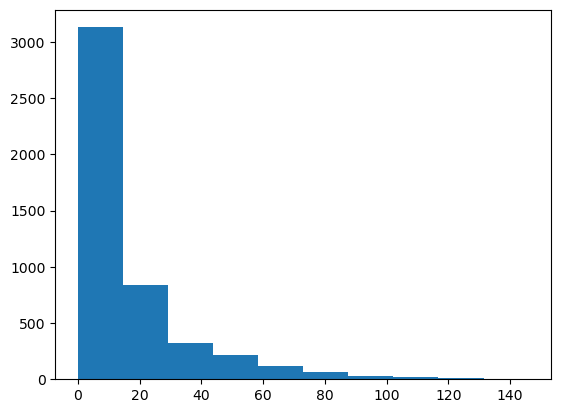

In [18]:
degrees = [A.degree(n) for n in A.nodes()]
plt.hist(degrees)
plt.show()

Plot the network (doesn't have to be pretty).

In [19]:
# nx.draw_networkx(A)
# plt.show()

Check if the network is connected:

In [20]:
nx.is_connected(A)

False

How many components are there?

In [21]:
nx.number_connected_components(A)

122

What is the size of the largest component?

In [22]:
cc = nx.connected_components(A)
gcc = A.subgraph(max(cc, key=len))
#gcc = max(nx.connected_components(A), key=len)
print(len(gcc))

4388


Plot the largest component (doesn't have to be pretty).

In [23]:
# nx.draw_networkx(gcc)
# plt.show()

### James Franco Number

##### (15 points)

In the 1990s they were interested in the [Kevin Bacon Number](https://simple.wikipedia.org/wiki/Bacon_number) which on a graph like ours would be the length of the shortest path between a given actress and Kevin Bacon. Also see [The Oracle of Bacon](https://oracleofbacon.org/how.php).

Let's do the same with the first actor on our list: James Franco!

Use `nx.shortest_path_length` to calculate all James Franco numbers in our graph. Notice NetworkX will calculate this only for James Franco's component, which is good enough for us, but think about what would be the shortest path to unconnected actors and what does this mean about the average you will be getting below.

In [86]:
james_franco_number = nx.shortest_path_length(A, target = 'James Franco')
type(james_franco_number)

dict

What is the average, median, minimum and maximum James Franco number?

In [87]:
jf = list(james_franco_number.values())
print('Mean James Franco Number: %.2f' % np.mean(jf))
print('Median James Franco Number: %.2f' % np.median(jf))
print('Max James Franco Number: %.2f' % np.max(jf))
print('Min James Franco Number: %.2f' % np.min(jf))

Mean James Franco Number: 2.64
Median James Franco Number: 3.00
Max James Franco Number: 7.00
Min James Franco Number: 0.00


What is the percentage of actors having James Franco Number of 3 or less?

In [26]:
jf3 = sum(x <= 3 for x in jf)
(jf3 / len(jf)) * 100

92.41112123974476

### Centrality

##### (15 points)

Compute the Degree, Eigen, Pagerank, Closeness and Betweenness centralities (may take some time):

In [88]:
cent_deg = nx.degree_centrality(A)
cent_eig = nx.eigenvector_centrality(A)
cent_pagerank = nx.pagerank(A)
cent_closeness = nx.closeness_centrality(A)
cent_betweenness = nx.betweenness_centrality(A)

Run this chunk to create a DataFrame with 5 columns, one for every centrality measure, and an `actor` column:

In [28]:
cent_df = pd.DataFrame([cent_deg, cent_eig, cent_pagerank, cent_closeness, cent_betweenness]).T.reset_index()
cent_df.columns = ['actor', 'degree', 'eigen', 'pagerank', 'closeness', 'betweenness']
cent_df[cent_df['actor'].isin(['Meryl Streep', 'Liam Neeson', 'James Franco', 'Cate Blanchett'])]

,actor,degree,eigen,pagerank,closeness,betweenness
25,Meryl Streep,0.011388,0.031699,0.000496,0.326436,0.001240
581,Liam Neeson,0.030789,0.094411,0.001342,0.357836,0.011891
732,James Franco,0.022564,0.051441,0.001038,0.350603,0.007604
1788,Cate Blanchett,0.012653,0.036013,0.000580,0.325076,0.001890


Use `cent_df` to print the top 5 central actors for every centrality measure:

In [29]:
for cent in cent_df.columns[1:]:
    print('Centrality %s:' % cent)
    print(cent_df.sort_values(cent, ascending=False)['actor'].head(5))
    print()

Centrality degree:
581        Liam Neeson
300       Michael Peña
1083    Bryan Cranston
549       John Goodman
139        Owen Wilson
Name: actor, dtype: object

Centrality eigen:
119         Paul Rudd
459    Bradley Cooper
581       Liam Neeson
143      Steve Carell
222      Kristen Wiig
Name: actor, dtype: object

Centrality pagerank:
300       Michael Peña
581        Liam Neeson
1083    Bryan Cranston
468       Kristen Bell
549       John Goodman
Name: actor, dtype: object

Centrality closeness:
1043         Emma Stone
300        Michael Peña
1170    Elizabeth Banks
581         Liam Neeson
459      Bradley Cooper
Name: actor, dtype: object

Centrality betweenness:
300       Michael Peña
581        Liam Neeson
1083    Bryan Cranston
468       Kristen Bell
110     Anthony Mackie
Name: actor, dtype: object



**Do you see the actor which is in the top 5 centrality by any measure? Look at this actor's films list and write why he's so central.**

In [30]:
### ???
ln = films_actors_edgelist.loc[films_actors_edgelist['actor']=="Liam Neeson", 'film'].to_list()
ln

['The A-Team',
 'The Chronicles of Narnia: The Voyage of the Dawn Treader',
 'Clash of the Titans',
 'The Next Three Days',
 'Unknown',
 'Battleship',
 'The Grey',
 'Star Wars: Episode I – The Phantom Menace 3D',
 'Wrath of the Titans',
 'Anchorman 2: The Legend Continues',
 'The Nut Job',
 'Non-Stop',
 'A Walk Among the Tombstones',
 'Taken 3',
 'Run All Night',
 'Mark Felt: The Man Who Brought Down the White House',
 'The Commuter',
 'The Ballad of Buster Scruggs',
 'Widows',
 'Cold Pursuit',
 'Men in Black: International']

### Community Detection

##### (15 points)

Use the Louvain method to detect communities of actors in **the giant component** of our network. Use `seed=42`.

In [89]:
communities = nx.community.louvain_communities(gcc, seed=42)

What is the modularity of the partition found by the algorithm?

In [90]:
print(nx.community.modularity(gcc, communities))

0.462588067700965


How many communities were found by the Louvain method? What is the average, median, minimum and maximum community size?

In [47]:
communities_size = [len(community) for community in communities]
print('Number of communities: %.2d' % len(communities))
print('Mean degree: %.2f' % np.mean(communities_size))
print('Median degree: %.2f' % np.median(communities_size))
print('Max degree: %.2f' % np.max(communities_size))
print('Min degree: %.2f' % np.min(communities_size))

Number of communities: 27
Mean degree: 162.52
Median degree: 133.00
Max degree: 502.00
Min degree: 20.00


In order to make some sense of the community structure found by the Louvain method, let us filter for each community only A-list actors, e.g. actors with at least 5 films in the decade. Also sort the actors alphabetically in each list:

In [69]:
actor2n_films = films_actors_edgelist.groupby('actor').size().to_dict()
a_list = [actor for actor, n_films in actor2n_films.items() if n_films >= 5]
print('Found %d actors with at least 5 films' % len(a_list))
communities_a_list = [[actor for actor in community if actor in a_list] for community in communities]

Found 722 actors with at least 5 films


For each community filtered print its actors:

In [70]:
for actors in communities_a_list:
    if len(actors) > 10:
        print(actors)
        print()

['Patricia Clarkson', 'Amy Seimetz', 'Ian McShane', 'Jeffrey Wright', 'Ted Levine', 'Jennifer Lawrence', 'Julianne Moore', 'Rafe Spall', 'Josh Hutcherson', 'Billy Crudup', 'Michelle Williams', 'Liam Hemsworth', 'Stanley Tucci', 'Ray Winstone', 'Woody Harrelson', 'Logan Lerman', 'Marisa Tomei', 'Djimon Hounsou', 'Elizabeth Banks', 'Toby Jones', 'Philip Seymour Hoffman', 'Sam Claflin', 'Jena Malone', 'Blake Lively']

['Regina Hall', 'Danny Glover', 'Loretta Devine', 'Tika Sumpter', 'Kevin Hart', 'Carmen Ejogo', 'Michael Ealy', 'Gabrielle Union', 'Mike Epps', 'Tyler Perry', 'Chad Michael Murray', 'Awkwafina', 'Danny DeVito']

['Christina Applegate', 'Jim Carrey', 'Brian Geraghty', 'Jenny Slate', 'Nicole Kidman', 'Harrison Ford', 'Joel Kinnaman', 'Jesse Plemons', 'Megan Fox', 'Paul Rudd', 'Tommy Lee Jones', 'Diane Kruger', 'Amy Poehler', 'Will Smith', 'Kristen Wiig', 'Taylor Kitsch', 'Fred Armisen', 'Luke Wilson', 'David Koechner', 'Frank Langella', 'Jemaine Clement', 'Ansel Elgort', 'Just

It's extremely hard to make sense of the communities and some of them don't really make sense, but if you followed thus far, you can see a few interesting ones.

Write a function which takes an A-list actor's name, and returns the (A-list) community to which this actor belongs (or an empty list of the actor was not found):

In [79]:
def get_actor_community(actor):
    for community in communities_a_list:
        if actor in community:
            return community
    return [] #empty list if the actor was not found

The Scarlett Johansson community looks like a "blockbuster" community, with all the Marvel stars (Chris Hemsworth, Chris Prat, Benedict Cumberbatch, Chadwick Boseman, Brie Larson, Idris Elba, Mark Ruffalo etc.).

In [80]:
get_actor_community('Scarlett Johansson')

['Natalie Portman',
 'Christopher Plummer',
 'Keira Knightley',
 'Jeremy Irons',
 'Dennis Quaid',
 'Angela Bassett',
 'Robin Wright',
 'Charlize Theron',
 'Ray Liotta',
 'Laura Dern',
 'Carey Mulligan',
 'Daisy Ridley',
 'Amy Adams',
 'Alex Pettyfer',
 'Dominic Cooper',
 'Gwyneth Paltrow',
 'Daniel Brühl',
 'Jai Courtney',
 'Ewan McGregor',
 'James Corden',
 'Rose Byrne',
 'Dwayne Johnson',
 'Brie Larson',
 'Benicio del Toro',
 'Eddie Marsan',
 'Justin Timberlake',
 'Matt Dillon',
 'Gina Rodriguez',
 'Rachel McAdams',
 'Britt Robertson',
 'Sam Rockwell',
 'Michelle Rodriguez',
 'Anthony Mackie',
 'Naomie Harris',
 'Dave Bautista',
 'Paul Bettany',
 'Colin Farrell',
 'Shailene Woodley',
 'Idris Elba',
 'Charlie Hunnam',
 'Jeff Goldblum',
 'Maika Monroe',
 'Michael Fassbender',
 'Adam Driver',
 'Judy Greer',
 'Rainn Wilson',
 'Margo Martindale',
 'Mary-Louise Parker',
 'Garrett Hedlund',
 'Chris Pratt',
 'Patrick Wilson',
 'Bruce Greenwood',
 'Mark Ruffalo',
 'Rene Russo',
 'Zachary Quin

The Tina Fey community looks like a "softer" films community, it includes Amy Poehler, Jim Carrey, Paul Rudd, Will Ferrell, etc.

In [81]:
get_actor_community('Tina Fey')

['Christina Applegate',
 'Jim Carrey',
 'Brian Geraghty',
 'Jenny Slate',
 'Nicole Kidman',
 'Harrison Ford',
 'Joel Kinnaman',
 'Jesse Plemons',
 'Megan Fox',
 'Paul Rudd',
 'Tommy Lee Jones',
 'Diane Kruger',
 'Amy Poehler',
 'Will Smith',
 'Kristen Wiig',
 'Taylor Kitsch',
 'Fred Armisen',
 'Luke Wilson',
 'David Koechner',
 'Frank Langella',
 'Jemaine Clement',
 'Ansel Elgort',
 'Justin Long',
 'Teresa Palmer',
 'Anna Faris',
 'Liam Neeson',
 'Tina Fey',
 'Vince Vaughn',
 'David Cross',
 'James Marsden',
 'Kirsten Dunst',
 'Will Ferrell',
 'Michiel Huisman',
 'Meagan Good',
 'Joaquin Phoenix',
 'Steve Carell',
 'Greg Kinnear',
 'Lucy Punch',
 'Hamish Linklater']

The Helena Bonham Carter community looks like the "Brits" community, it includes: Alan Rickman, Emily Blunt, Hugh Laurie, Emma Watson, Daniel Radcliffe, Ralph Fiennes, Maggie Smith etc.

In [82]:
get_actor_community('Helena Bonham Carter')

['Lily James',
 'Catherine Zeta-Jones',
 'Brenton Thwaites',
 'Matthew Lillard',
 'Asa Butterfield',
 'Justin Bartha',
 'Bill Nighy',
 'Imelda Staunton',
 'Colin Firth',
 'Julie Walters',
 'Alan Rickman',
 'Maggie Smith',
 'Katherine Waterston',
 'Emma Watson',
 'Nicholas Hoult',
 'Kaya Scodelario',
 'Patrick Stewart',
 'Emily Blunt',
 'Brendan Gleeson',
 'Steve Coogan',
 'Malin Åkerman',
 'Oliver Platt',
 'Emma Thompson',
 'Chloë Grace Moretz',
 'Danny Huston',
 'Juno Temple',
 'Boyd Holbrook',
 'Craig Ferguson',
 'Claire Foy',
 'Taron Egerton',
 'Hugh Jackman',
 'Javier Bardem',
 'Matt Lucas',
 'Ralph Fiennes',
 'Stana Katic',
 'Daniel Radcliffe',
 'Rebecca Hall',
 'Sam Worthington',
 'Dan Fogler',
 'Alice Eve',
 'Hugh Laurie',
 'Stephen Merchant',
 'Helena Bonham Carter',
 'Jude Law',
 'Johnny Depp',
 'Eddie Redmayne']

**Not all communities make sense**

For example Daisy Ridley's community incorporates her Star Wars colleagues (Mark Hamill, John Boyega, Adam Driver), but also... Jenna Fischer and Laura Dern.

In [83]:
get_actor_community('Daisy Ridley')

['Natalie Portman',
 'Christopher Plummer',
 'Keira Knightley',
 'Jeremy Irons',
 'Dennis Quaid',
 'Angela Bassett',
 'Robin Wright',
 'Charlize Theron',
 'Ray Liotta',
 'Laura Dern',
 'Carey Mulligan',
 'Daisy Ridley',
 'Amy Adams',
 'Alex Pettyfer',
 'Dominic Cooper',
 'Gwyneth Paltrow',
 'Daniel Brühl',
 'Jai Courtney',
 'Ewan McGregor',
 'James Corden',
 'Rose Byrne',
 'Dwayne Johnson',
 'Brie Larson',
 'Benicio del Toro',
 'Eddie Marsan',
 'Justin Timberlake',
 'Matt Dillon',
 'Gina Rodriguez',
 'Rachel McAdams',
 'Britt Robertson',
 'Sam Rockwell',
 'Michelle Rodriguez',
 'Anthony Mackie',
 'Naomie Harris',
 'Dave Bautista',
 'Paul Bettany',
 'Colin Farrell',
 'Shailene Woodley',
 'Idris Elba',
 'Charlie Hunnam',
 'Jeff Goldblum',
 'Maika Monroe',
 'Michael Fassbender',
 'Adam Driver',
 'Judy Greer',
 'Rainn Wilson',
 'Margo Martindale',
 'Mary-Louise Parker',
 'Garrett Hedlund',
 'Chris Pratt',
 'Patrick Wilson',
 'Bruce Greenwood',
 'Mark Ruffalo',
 'Rene Russo',
 'Zachary Quin

### Paper questions

##### (15 points)

Read Overgoor et. al. [Structure of U.S. College Networks on Facebook](https://ojs.aaai.org/index.php/ICWSM/article/view/7318) AAAI 2020 paper, first 6 pages (of course you're invited to read the whole thing!)

What is the density of the US college networks graph (it's a simple computation)?

In [84]:
nodes = 7.6 * 10 ** 6
edges = 756.5 * 10 ** 6
density = (2 * edges) / (nodes * (nodes - 1))
print(density)

2.6194601784608267e-05


In your own up to 100 words, what is described in Figure 6? Copy pasting from the paper will lead to zero points.

In [ ]:
# The "distance" metric, as defined in the paper, measures how distinguishable two networks are.
# To calculate the distance, a RF classifier is trained for each pair of schools using their generated ego graphs as the
# training data. The distance is the resulting cross-validated AUC for the model, with values close to 1 indicating the
# networks are distinguishable, and values close to 0.5 indicating they are not.
# Figure 6 decribes a distance matrix for a sample of the 2011 class from 20 different schools from different categories
# (public/private, low/high admission rates).

In [ ]:
# The "distance" metric, as defined in the paper is the resulting cross-validated AUC for the model, with values close to 1 indicating the
# networks are distinguishable, and values close to 0.5 indicating they are not.
# Figure 6 decribes a distance matrix for a sample of the 2011 class from 20 different schools from different categories:
#- Public schools with a low admission rate (red color)
#- Public schools with a high admission rate (blue color)
#- Private schools with a low admission rate (green color)
#- Private schools with a high admission rate (purple color)

### Wrap up
And that's it, you have shown you can use NetworkX to build interesting networks, find some interesting facts and metrics about them and run community detection algorithms. Good luck with the rest of the course!